## Analyze A/B Test Results


## Table of Contents

- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusions](#conclusions)
- [Part V - Resources](#resources)


<a id='probability'></a>
#### Part I - Probability


In [1]:
# Import all the necessary packages 
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
# Load movies' data frame
df =  pd.read_csv('ab_data.csv')

# Inspect dataset
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# find out the number of rows in the dataset and print out this figure
row_no = df.shape[0]
print('The number of rows in the dataset: ' + str(row_no))

The number of rows in the dataset: 294478


In [4]:
# Find out the number of unique users in the dataset.
unique_users=len(df.groupby('user_id'))
print('The number of unique users in the dataset: ' + str(unique_users))

The number of unique users in the dataset: 290584


In [5]:
# The proportion of users converted.
conv_user= df['converted'].mean()
print('The proportion of users converted: ' + str(conv_user))

The proportion of users converted: 0.11965919355605512


In [6]:
# The number of times the `new_page` and `treatment` don't line up.
query_mask = df.query("landing_page == 'new_page' and group != 'treatment'").count()[0] + \
df.query("landing_page != 'new_page' and group == 'treatment'").count()[0] 
print('The number of times the new page and treatment do not line up is: ' + str(query_mask) )

The number of times the new page and treatment do not line up is: 3893


In [7]:
#Another way
df.query("(landing_page == 'new_page' and group == 'control') or  \
(landing_page == 'old_page' and group == 'treatment')").shape[0] 

3893

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB



<strong><u>No missing values have been found</u></strong>

In [9]:
# Drop the rows where treatment is not aligned with new_page or control is not aligned with old_page, 
# because it is not clear if this row truly received the new or old page.
df.drop(df.query("group == 'treatment' and landing_page != 'new_page'").index, inplace = True)
df.drop(df.query("group == 'control' and landing_page != 'old_page'").index, inplace = True)
df2 = df

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# Find out the number of rows after deleting 
df2.shape[0]

290585

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2.query("group == 'treatment' and landing_page != 'new_page'").count()[0] + \
df2.query("group == 'control' and landing_page != 'old_page'").count()[0]

0

In [13]:
# Find out how many unique user_ids are in df2?
len(df2.groupby('user_id'))

290584

In [14]:
# Show the information for the repeat user_id
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
# Remove one of the duplicated user_id 
dup_user = "2017-01-09 05:37:58.781806"
df2 = df2[df2.timestamp != dup_user]

In [16]:
# Check 
df2.query("user_id == 773192 ")

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
# Find out the number of rows in the new dataset after cleaing the dataset
df2.shape

(290584, 5)

In [18]:
# Find out the data type of the new dataset
df2.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object


<strong><u>Data Type error:<br> </u> Timestamp should have date time data type.
May be, need to change the type ....</strong>

In [19]:
# to know how many users converted and how many not
df2.groupby('converted').size()

converted
0    255831
1     34753
dtype: int64

In [20]:
# Proportion of the Converted 
conv_user= df2['converted'].value_counts()[1] / df2['converted'].count()
print('The proportion of users converted: ' + str(conv_user))

The proportion of users converted: 0.11959708724499628


In [21]:
# The probability converted in the control group

control = df2.query("group == 'control' and converted == 1").count()[4] / df2[df2['group'] == 'control'].count()[4]
print('The probability converted in the control group: ' + str(control))


The probability converted in the control group: 0.1203863045004612


In [22]:
# The probability converted in the control group

treat = df2.query("group == 'treatment' and converted == 1").count()[4] / df2[df2['group'] == 'treatment'].count()[4]
print('The probability converted in the treatment group: ' + str(treat))


The probability converted in the treatment group: 0.11880806551510564


In [23]:
new_page = df2.query("landing_page == 'new_page'").count()[3] / df2['landing_page'].count()

print('Th probability that an individual received the new page: ' + str(new_page))

Th probability that an individual received the new page: 0.5000619442226688


#### Accroding the above proportions:

- There are at least 50% of users willing to land new pages.
- There are only around 11.96% of users convert to new version.
- In addition, the probability of an individual received the new page in either "control" or "treatment" groups are around 12% 

I beleive that we can't conclude that the new treatment page leads to more conversions. May be it would be better to run the experiment longer to make the right decision.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$
 $$H_1: p_{new} - p_{old} > 0$$

**Or another way**
$$ H_0: p_{new} \leq p_{old}$$ 
$$ H_1: p_{new} > p_{old}$$ 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
# The convert rate for  𝑝𝑛𝑒𝑤  under the null
p_new = df2['converted'].mean()
print('The convert rate for 𝑝_𝑛𝑒𝑤  under the null: ' + str(p_new))

The convert rate for 𝑝_𝑛𝑒𝑤  under the null: 0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
p_old = df2['converted'].mean()
print('The convert rate for 𝑝_old  under the null: ' + str(p_old))

The convert rate for 𝑝_old  under the null: 0.11959708724499628


c. What is $n_{new}$?

In [26]:
𝑛_𝑛𝑒𝑤 = df[df['group'] == 'treatment'].shape[0]
print('n_𝑛𝑒𝑤 : ' + str(n_𝑛𝑒𝑤))

n_𝑛𝑒𝑤 : 145311


d. What is $n_{old}$?

In [27]:
𝑛_old = df[df['group'] == 'control'].shape[0]
print('n_old : ' + str(n_old))

n_old : 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.binomial( 1, p_𝑛𝑒𝑤, n_new)

print('New page converted : ' + str(new_page_converted))

New page converted : [0 0 0 ... 0 0 0]


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.binomial(1, p_old, n_old)
print('Old page converted : ' + str(old_page_converted))

Old page converted : [1 0 0 ... 0 0 0]


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [31]:
p_diff = new_page_converted.mean()-old_page_converted.mean()
print(p_diff)


-0.0011453232038838995


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [32]:
p_diffs =[]
for value in range (10000):
    new_page_converted = np.random.binomial( n_𝑛𝑒𝑤, p_new)
    old_page_converted = np.random.binomial( n_old, p_old)
    p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

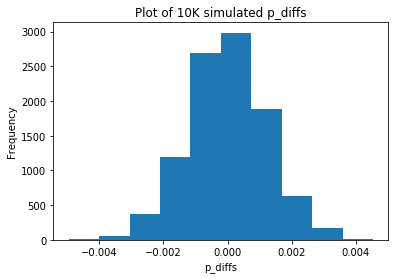

In [33]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Plot of 10K simulated p_diffs');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
#Actual difference of converted rates
actual_diff = (df2[df2['group'] == "treatment"]['converted'].mean()) - (df2[df2['group'] == "control"]['converted'].mean())
actual_diff

-0.0015782389853555567

In [35]:
p_diffs = np.array(p_diffs)
p_diffs

array([-0.00117288, -0.00195073, -0.00095277, ...,  0.00058888,
       -0.00029898, -0.00016118])

In [36]:
#Convert to numpy array and calculate the p-value
p_diffs = np.array(p_diffs)
(p_diffs > actual_diff).mean()

0.9043

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

## Answer
- Computing p-values.
- This is the probability of observing our statistic if the null hypothesis is true.
- The more extreme in favor of the alternative portion of this statement determines the shading associated with your p-value.
- There is no conversion advantage with new pages. We conclude that null hypothesis is true as old and new pages perform almost similarly. Old pages, as the numbers show, performed slightly better.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [39]:
import statsmodels.api as sm

#Number of conversions for each page
convert_old = sum(df2.query('group == "control"')['converted'])
convert_new = sum(df2.query('group == "treatment"')['converted'])

#Number of individuals who received each page
n_old = df2.query("group == 'control'")['user_id'].count()
n_new = df2.query("group == 'treatment'")['user_id'].count()

#Convert figures to integers
n_old = int(n_old)
n_new = int(n_new)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [41]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new,n_old], alternative='larger')

print(z_score)

-1.3109241984234394


In [42]:
p_value

0.9050583127590245

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [91]:
from scipy.stats import norm

# How significant our z-score is
print(norm.cdf(z_score))


# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))

# Tells us what our critical value at 95% confidence is 
# Here, we take the 95% values as specified in PartII.1

0.9050583127590245
1.6448536269514722


**Answer:**
- The z-score of is less than the critical value. So, we accept the null hypothesis.
- p-value determines the significance of our resuls. The values are different from parts j and k but it still suggests that there is no statistically significant difference betweem the new and the old page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [43]:
df2['intercept']=1
df2[['control', 'ab_page']]=pd.get_dummies(df2['group'])
df2.drop(labels=['control'], axis=1, inplace=True)
df2.head()

C:\Users\manal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\manal\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\manal\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [44]:
import statsmodels.api as sm

mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = mod.fit() #Fitting the model

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [45]:
results.summary() #Summary of our test results.

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        22:56:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value suggests that the new page is not statistically significant as 0.19 > 0.05. The values are different because in part 2 we randomly sampled the data 10000 times and the sample could have overlapped or been mutually exclusive to an extent to give different values such that differet p-values were received than what we got in logistic regression..**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Considering other factors/explanatory variables makes our hypothesis results more reliable as it can improve the r-sqaured values plus we might miss other influencing factors of out response variables. But if multicolinearity exists, that is correlation between explanatory variables then our results will be wrong. So we need to make sure that there is no multicolinearity.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [46]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner') #Merging 2 data frames with index as user_id
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [47]:
# Finding unique countries in dataset
countries_df['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [48]:
### Create the necessary dummy variables
df_new[['CA','US','UK']] = pd.get_dummies(df_new['country'])[['CA','US','UK']]

In [50]:
#confirming if the dummies inherit correct values by comparing dummy column values to country column
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,US,UK
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1


In [51]:
### Fit Your Linear Model And Obtain the Results
log_mod_countries = sm.Logit(df_new['converted'],df_new[['intercept','US','UK']])
results_countries = log_mod_countries.fit()
results_countries.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 03 May 2019   Pseudo R-squ.:               1.521e-05
Time:                        23:02:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [52]:

# Creating new columns for interaction between page and country
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,US,UK,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1


In [53]:
# Fit toLinear Model And Obtain the Results
log_mod_int = sm.Logit(df_new['converted'],df_new[['intercept','US','UK','ab_page','US_ab_page','UK_ab_page']])
results_int = log_mod_int.fit()
results_int.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 03 May 2019   Pseudo R-squ.:               3.482e-05
Time:                        23:04:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""

**Result: p-value is still higher than alpha, fail to reject null**

<a id='conclusions'></a>
## Conclusions

Based on this analysis, there is no practical significance in rolling out the new page over old page. Conversion rate for old page is better than new one. 
Comparing users among different countries also doesn't show considerable difference in statistics. 

<a id='resources'></a>
## Resources
- Udacity Data Analyst Nanodegree
- https://www.youtube.com/watch?v=7FTp9JJ5DfE&feature=youtu.be Practical Stats Project Walkthrough Final
- https://www.khanacademy.org/
- http://www.statisticshowto.com/probability-and-statistics
